In [1]:
import os
import cv2 
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics
from keras.optimizers import Adam
import time 

In [ ]:
# Below is the function which loads the images
def load_images(folder, batch_size, start_idx, img_size=None):
    batch = []  
    files = os.listdir(folder)  
    end_idx = min(start_idx + batch_size, len(files))  
    for file in files[start_idx:end_idx]:  
        path = os.path.join(folder, file)  
        img = cv2.imread(path)  
        if img is not None:  
            if img_size:  
                img = cv2.resize(img, img_size)
            batch.append(img)  

    return np.array(batch), end_idx  


# 2. Below are the functions which add noise to images 

def gaussian_noise(image, mean=0, stddev=25):
    noise = np.random.normal(mean, stddev, image.shape).astype(np.float32)
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image

def salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    noisy_image = image.copy()
    total_pixels = image.size
    num_salt = int(total_pixels * salt_prob)
    num_pepper = int(total_pixels * pepper_prob)
    salt_coords = [np.random.randint(0, i-1, num_salt) for i in image.shape]
    noisy_image[salt_coords[0], salt_coords[1], :] = 255
    pepper_coords = [np.random.randint(0, i-1, num_pepper) for i in image.shape]
    noisy_image[pepper_coords[0], pepper_coords[1], :] = 0
    return noisy_image

def speckle_noise(image):
    noise = np.random.randn(*image.shape) * 0.2 
    noisy_image = np.clip(image + image * noise, 0, 255).astype(np.uint8)
    return noisy_image

# We are adding only one type of noise at random to the image

def noise_add(images):
    noisy_images = []
    for image in images:
        noise_type = np.random.choice(['gaussian', 'salt_and_pepper', 'speckle'])
        if noise_type == 'gaussian':
            noisy_images.append(gaussian_noise(image))
        elif noise_type == 'salt_and_pepper':
            noisy_images.append(salt_and_pepper_noise(image))
        elif noise_type == 'speckle':
            noisy_images.append(speckle_noise(image))
    return np.array(noisy_images)

In [ ]:

train_clean_path = "/kaggle/input/denoising/train/twenty_fivek_hr"  
test_clean_path = "/kaggle/input/denoising/test/twenty_fivek_hr"
batch_size = 500 

In [ ]:
# Now, we are building our CNN model to denoise the images
# Model should be light weight and should have low inference time while maintaining a good accuracy because
# this model is a part of bigger pipeline
# We have added four layers to keep model light weight and low inference time

# input_shape=(256,256,3)

# model = models.Sequential([
#         layers.Input(shape=input_shape),
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
#         layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#         layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')  
#     ])
# model.compile(
#     optimizer=Adam(learning_rate=0.001), 
#     loss='mean_squared_error',          
#     metrics=['accuracy']                
# )

# I have commented this code because i have already trained it and i am loading it from previously trained model

In [ ]:
# # Now we are training loop
# num_epochs = 10
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch + 1}/{num_epochs}")
#     start_index = 0
#     while True:
#         print(f"Processing images from index {start_index}...")
#         # Load a batch of clean images
#         train_clean_images, start_index = load_images(train_clean_path, batch_size, start_index, (256,256))
#         if train_clean_images.size == 0:  
#             break
#         # Add noise
#         train_noisy_images = noise_add(train_clean_images)

#         # Normalize
#         train_clean_images = train_clean_images / 255.0
#         train_noisy_images = train_noisy_images / 255.0

#         # Train on the batch
#         model.fit(
#             train_noisy_images, train_clean_images,
#             batch_size=50,  
#             epochs=1,
#             verbose=1
#         )

# I have already trained my model so i am loading my previously trained model

In [ ]:
# model.save("denoising_model.h5")

# This command is for saving the model architecture and its weight

In [2]:
# Load the entire model, specifying custom objects
trained_model = load_model("/kaggle/input/m/aastha2807/denoising/pytorch/default/1/denoising_model.h5", custom_objects={'mse': metrics.MeanSquaredError()})


In [ ]:
# Compiling the model in case we need to train the model again
trained_model.compile(
    optimizer=Adam(learning_rate=0.001),  # Create a new optimizer
    loss='mean_squared_error',           # Use the appropriate loss function
    metrics=['accuracy']                 # Optional metrics
)

In [3]:
# Printing the summary of model
print(trained_model.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,053 (226.77 KB)

 Trainable params: 58,051 (226.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


In [ ]:
# Now we are evaluating the Model
print("Evaluating on test dataset...")
start_index = 0
test_clean_images,_ = load_images(test_clean_path, batch_size, start_index, (256,256))
test_noisy_images = noise_add(test_clean_images)
test_clean_images = test_clean_images / 255.0
test_noisy_images = test_noisy_images / 255.0

test_loss, test_accuracy = trained_model.evaluate(test_noisy_images, test_clean_images)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# Now we are visualizing the images
def show_images(clean, noisy, denoised):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Clean Image")
    plt.imshow(clean)
    plt.subplot(1, 3, 2)
    plt.title("Noisy Image")
    plt.imshow(noisy)
    plt.subplot(1, 3, 3)
    plt.title("Denoised Image")
    plt.imshow(denoised)
    plt.show()

# Visualizing 10 random samples from test dataset
for _ in range(10):
    random_index = np.random.randint(0, len(test_clean_images))
    noisy_sample = test_noisy_images[random_index]
    denoised_sample = trained_model.predict(np.expand_dims(noisy_sample, axis=0))[0]
    
    show_images(test_clean_images[random_index], noisy_sample, denoised_sample)


In [ ]:
# Now , we are checking model inference time on GPU
test_images_subset = test_noisy_images[:100]  

gpu_inference_times = []

with tf.device('GPU:0'):  
    for img in test_images_subset:
        img = np.expand_dims(img, axis=0)  
        start_time = time.time()
        trained_model.predict(img)
        end_time = time.time()
        inference_time = end_time - start_time
        gpu_inference_times.append(inference_time)

avg_gpu_inference_time = np.mean(gpu_inference_times)
print(f"Average Inference Time on GPU for 100 images: {avg_gpu_inference_time:.6f} seconds")


In [11]:
def show_images(high, low, enhanced):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(high)
    plt.axis('off')  

    plt.subplot(1, 3, 2)
    plt.title("Input Image")
    plt.imshow(low)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Denoised Image")
    plt.imshow(enhanced)
    plt.axis('off')

    plt.show()

In [13]:
import cv2 as cv
img = cv.imread("/kaggle/input/random-testing/test_img.png", cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img, (256,256))
img = img.astype('float32') / 255.0

img_tensortest = tf.convert_to_tensor(img, dtype=tf.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


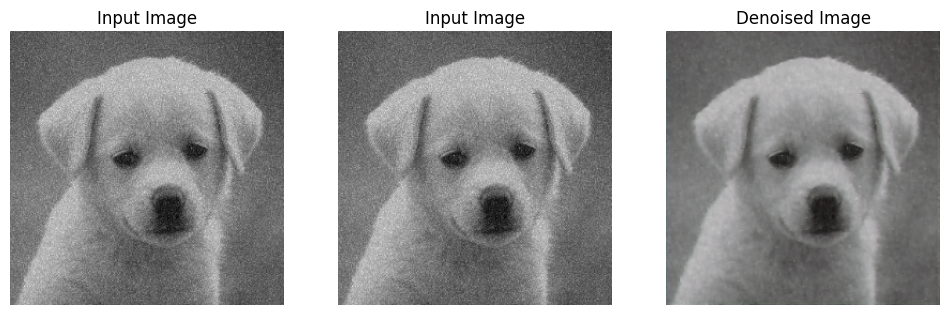

In [14]:
enhanced_sample = trained_model.predict(np.expand_dims(img_tensortest, axis=0))[0]  

show_images(img_tensortest, img_tensortest, enhanced_sample)

In [15]:
import cv2 as cv
img = cv.imread("/kaggle/input/random-testing/test2_img.png", cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img, (256,256))
img = img.astype('float32') / 255.0

img_tensortest = tf.convert_to_tensor(img, dtype=tf.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


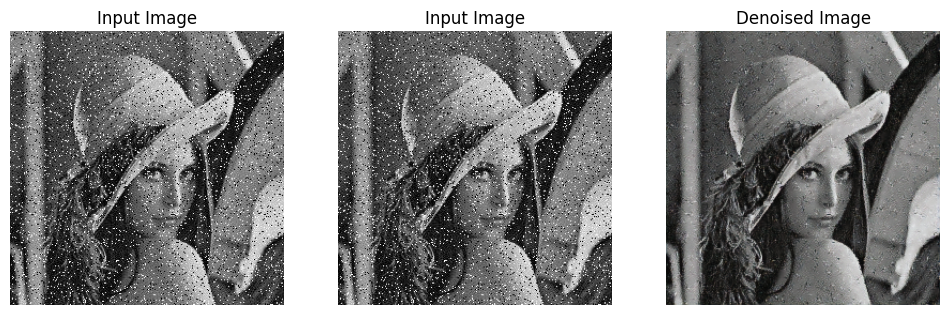

In [16]:
enhanced_sample2 = trained_model.predict(np.expand_dims(img_tensortest, axis=0))[0]  

show_images(img_tensortest, img_tensortest, enhanced_sample2)

In [17]:
import cv2 as cv
img = cv.imread("/kaggle/input/random-testing/test3_img.png", cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img, (256,256))
img = img.astype('float32') / 255.0

img_tensortest = tf.convert_to_tensor(img, dtype=tf.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


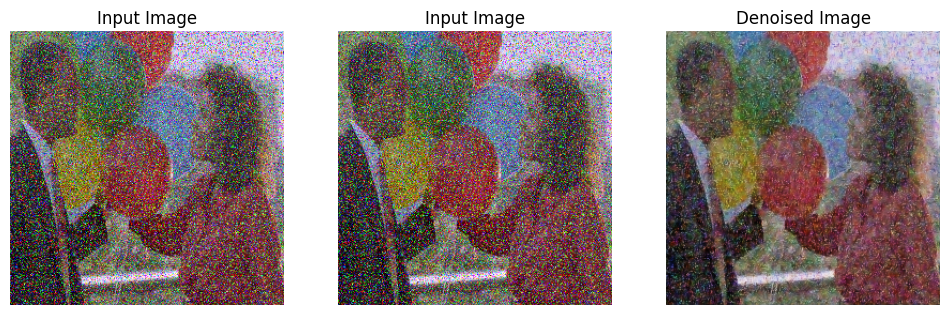

In [18]:
enhanced_sample3 = trained_model.predict(np.expand_dims(img_tensortest, axis=0))[0]  

show_images(img_tensortest, img_tensortest, enhanced_sample3)

In [9]:
import cv2 as cv
img = cv.imread("/kaggle/input/random-testing/test4_img.png", cv.IMREAD_COLOR)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img, (256,256))
img = img.astype('float32') / 255.0

img_tensortest = tf.convert_to_tensor(img, dtype=tf.float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


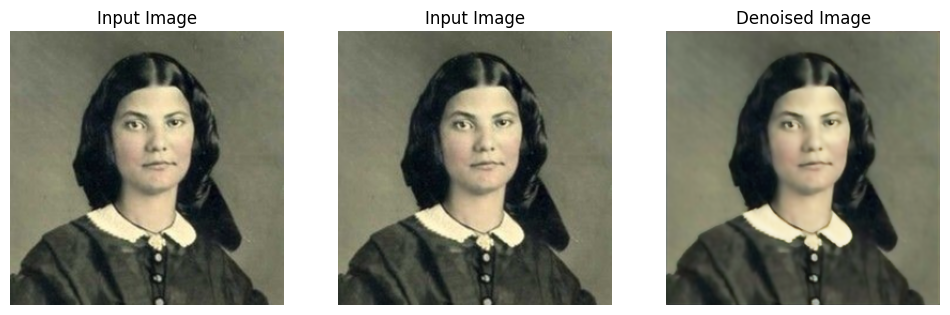

In [12]:
enhanced_sample3 = trained_model.predict(np.expand_dims(img_tensortest, axis=0))[0]  

show_images(img_tensortest, img_tensortest, enhanced_sample3)